In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import LayeredNetworkGraph as lng
from numpy import mean
from numpy import std
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [2]:
ldensity = []
ldegree = []
lclustering = []

In [6]:
aodv = pd.read_csv('slow.csv', sep = ';')
hosts = aodv[aodv.destino == '127.0.0.0']['origem']
eventos = aodv[aodv.timestamp != 0][['acao', 'timestamp', 'origem', 'destino', 'gateway']]

In [7]:
# processamento da tabela de rotamento com variação no tempo
start = 0 # eventos.iloc[0]['timestamp'] # primeiro evento de alteração da tabela de roteamento, em segundos
stop = 300 # condição de parada em segundos
offset = 1000 # offset em milisegundos a partir do instante 'start'

layers = []
timestamp = []
densidade = []
clustering = []
caminho_medio = []
diametro = []
degree = []
t = start
while t <= stop:
    rotas = []
    for idx, e in eventos[eventos.timestamp <= t].iterrows():
        cria = False
        rota = next((r for r in rotas if r['origem'] == e['origem'] and r['destino'] == e['destino']), None)
        if rota == None:
            cria = True
            rota = {'origem': e['origem'], 'destino': e['destino'], 'gateway': e['gateway']}
        if '+' in e['acao'] and cria: # criação de nova rota
            rotas.append(rota)
        elif '*' in e['acao']: # alteração de rota existente
            rota.update({'gateway': e['gateway']})
        else: # removação de rota existente
            rotas.remove(rota)
    
    # construção do grafo
    G = nx.DiGraph()
    c = 1
    for h in hosts:
        G.add_node(h, **{'c':c})
        c += 1
    for r in rotas:
        G.add_edge(r['origem'], r['gateway'])

    # adiciona layer
    layers.append(G)
    
    # cálculo das métricas
    timestamp.append(t)
    densidade.append(nx.density(G))
    clustering.append(nx.average_clustering(G))
    try:
        caminho_medio.append(nx.average_shortest_path_length(G))
    except:
        caminho_medio.append(None)
    try:
        diametro.append(nx.diameter(G))
    except:
        diametro.append(None)
    dg = []
    for n, d in nx.degree(G):
        dg.append(d)
    degree.append(mean(dg))
    t += offset / 1000

ldensity.append(densidade) 
ldegree.append(degree)
lclustering.append(clustering)
# desenha multi-layer graph
#layers.reverse()
#node_labels = {n: G.nodes[n]['c'] for n in G.nodes()}
#fig = plt.figure(figsize=(8, 6), dpi=120)
#ax = fig.add_subplot(111, projection='3d')
#lng.LayeredNetworkGraph(layers, ax=ax, node_labels=node_labels, layout=nx.spring_layout)
#ax.set_axis_off()
#plt.show()

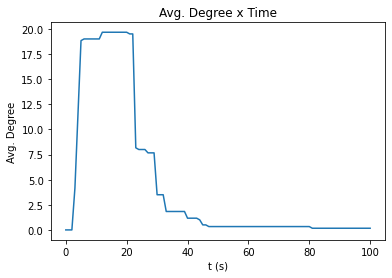

In [12]:
# grau médio x tempo
plt.title("Avg. Degree x Time")
plt.xlabel("t (s)")
plt.ylabel("Avg. Degree")
plt.plot(timestamp, degree);

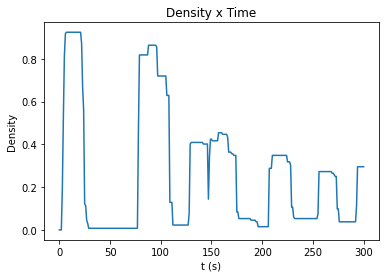

In [8]:
# densidade x tempo
plt.title("Density x Time")
plt.xlabel("t (s)")
plt.ylabel("Density")
plt.plot(timestamp, densidade);

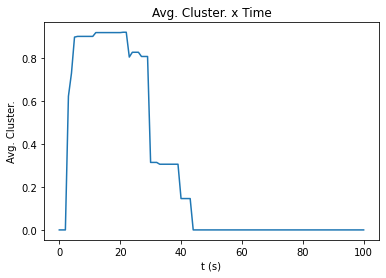

In [144]:
# coef. de clusterização médio x tempo
plt.title("Avg. Cluster. x Time")
plt.xlabel("t (s)")
plt.ylabel("Avg. Cluster.")
plt.plot(timestamp, clustering);

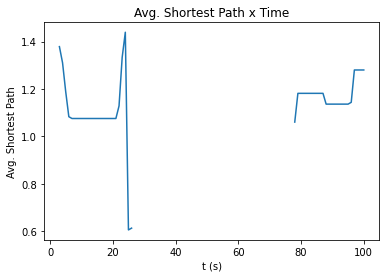

In [62]:
# caminho mínimo médio x tempo
plt.title("Avg. Shortest Path x Time")
plt.xlabel("t (s)")
plt.ylabel("Avg. Shortest Path")
plt.plot(timestamp, caminho_medio);

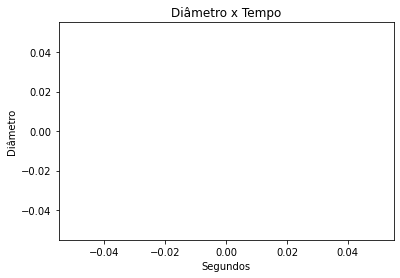

In [13]:
# diâmetro da rede x tempo
plt.title("Diâmetro x Tempo")
plt.xlabel("Segundos")
plt.ylabel("Diâmetro")
plt.plot(timestamp, diametro);

Snapshot: 75.00 segundo(s)
Fracamente conectado: False
Fortemente conectado: False
Grau médio: 0.16666666666666666
Densidade: 0.007575757575757576
Coef. clusterização médio: 0.0
Menor caminho médio: -
Diâmetro: -


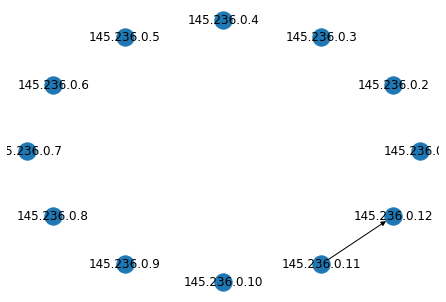

In [17]:
# processamento da tabela de rotamento até o instante determinado
snap_shot = 75 # tempo do snapshot em segundos
rotas = []
for idx, e in eventos[eventos.timestamp <= snap_shot].iterrows():
    cria = False
    rota = next((r for r in rotas if r['origem'] == e['origem'] and r['destino'] == e['destino']), None)
    if rota == None:
        cria = True
        rota = {'origem': e['origem'], 'destino': e['destino'], 'gateway': e['gateway']}
    if '+' in e['acao'] and cria: # criação de nova rota
        rotas.append(rota)
    elif '*' in e['acao']: # alteração de rota existente
        rota.update({'gateway': e['gateway']})
    else: # removação de rota existente
        rotas.remove(rota)   

# construção do grafo
G = nx.DiGraph()
for h in hosts:
    G.add_node(h)
for r in rotas:
    G.add_edge(r['origem'], r['gateway'])

# cálculo das métricas
dg = []
for n, d in nx.degree(G):
    dg.append(d)
media = mean(dg)
sigma = std(dg)
print('Snapshot: {0:0.2f} segundo(s)'.format(snap_shot))
print('Fracamente conectado: {0}'.format(nx.is_weakly_connected(G)))
print('Fortemente conectado: {0}'.format(nx.is_strongly_connected(G)))
print('Grau médio: {0}'.format(media))
print('Densidade: {0}'.format(nx.density(G)))
print('Coef. clusterização médio: {0}'.format(nx.average_clustering(G)))
try:
    print('Menor caminho médio: {0}'.format(nx.average_shortest_path_length(G)))
except:
    print('Menor caminho médio: -')
try:
    print('Diâmetro: {0}'.format(nx.diameter(G)))
except:
    print('Diâmetro: -')

# desenho do grafo
nx.draw(G, pos=nx.circular_layout((G)), with_labels=True)

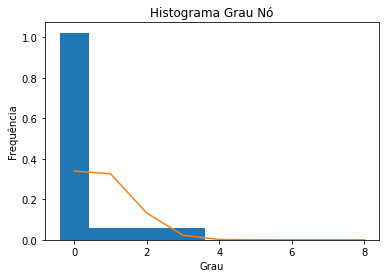

In [39]:
# análise estatísticas do grau do nós
# aproximação usando uma PDF gaussiana
dist = norm(media, sigma)
valores = range(0, max(dg) + 5)
prob = [dist.pdf(x) for x in valores]
plt.title("Histograma Grau Nó")
plt.xlabel("Grau")
plt.ylabel("Frequência")
plt.hist(x=dg, bins=5, align='left', density=True)
plt.plot(valores, prob);

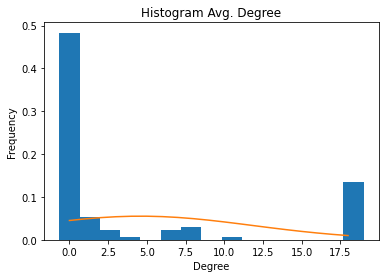

In [95]:
# análise estatística do grau médio da rede
# aproximação usando PDF gaussiana
md = mean(degree)
sd = std(degree)
dist = norm(md, sd)
valores = range(0, int(max(degree)))
prob = [dist.pdf(x) for x in valores]
plt.title("Histogram Avg. Degree")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.hist(x=degree, bins=15, align='left', density=True)
plt.plot(valores, prob);

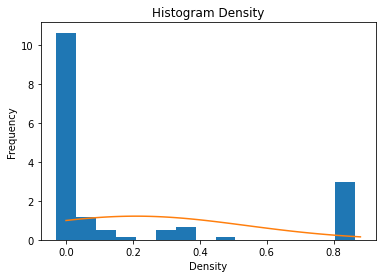

In [96]:
# análise estatística da densidade da rede
# aproximação usando PDF gaussiana
md = mean(densidade)
sd = std(densidade)
dist = norm(md, sd)
valores = list(range(0, int(100 * max(densidade))))
valores = [x / 100 for x in valores]
prob = [dist.pdf(x) for x in valores]
plt.title("Histogram Density")
plt.xlabel("Density")
plt.ylabel("Frequency")
plt.hist(x=densidade, bins=15, align='left', density=True)
plt.plot(valores, prob);

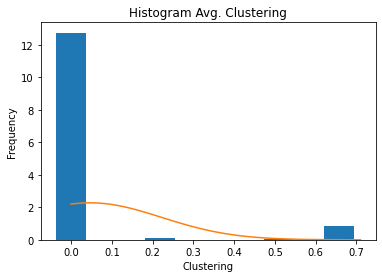

In [33]:
# análise estatística do coef. médio de clusterização da rede
# aproximação usando PDF gaussiana
md = mean(clustering)
sd = std(clustering)
dist = norm(md, sd)
valores = list(range(0, int(100 * max(clustering))))
valores = [x / 100 for x in valores]
prob = [dist.pdf(x) for x in valores]
plt.title("Histogram Avg. Clustering")
plt.xlabel("Clustering")
plt.ylabel("Frequency")
plt.hist(x=clustering, bins=10, align='left', density=True)
plt.plot(valores, prob);

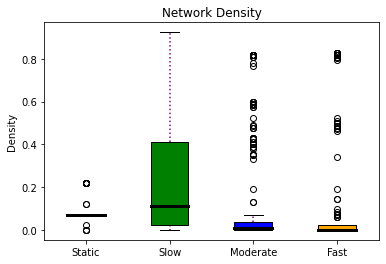

In [47]:
plt.title("Network Density");
plt.ylabel("Density");
bp = plt.boxplot(ldensity, patch_artist = True, labels = ["Static", "Slow", "Moderate", "Fast"]);

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":");
    
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3);
    
bp['boxes'][0].set(facecolor = "red");
bp['boxes'][1].set(facecolor = "green");  
bp['boxes'][2].set(facecolor = "blue");  
bp['boxes'][3].set(facecolor = "orange");  

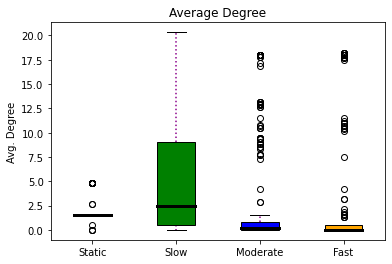

In [42]:
plt.title("Average Degree");
plt.ylabel("Avg. Degree");
bp = plt.boxplot(ldegree, patch_artist = True, labels = ["Static", "Slow", "Moderate", "Fast"]);

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":");
    
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3);
    
bp['boxes'][0].set(facecolor = "red");
bp['boxes'][1].set(facecolor = "green");  
bp['boxes'][2].set(facecolor = "blue");  
bp['boxes'][3].set(facecolor = "orange");  

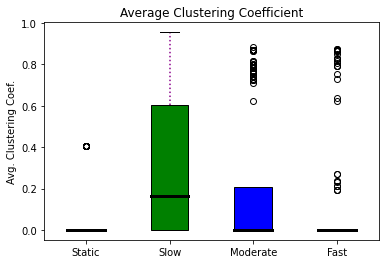

In [43]:
plt.title("Average Clustering Coefficient");
plt.ylabel("Avg. Clustering Coef.");
bp = plt.boxplot(lclustering, patch_artist = True, labels = ["Static", "Slow", "Moderate", "Fast"]);

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":");
    
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3);
    
bp['boxes'][0].set(facecolor = "red");
bp['boxes'][1].set(facecolor = "green");  
bp['boxes'][2].set(facecolor = "blue");  
bp['boxes'][3].set(facecolor = "orange"); 
    

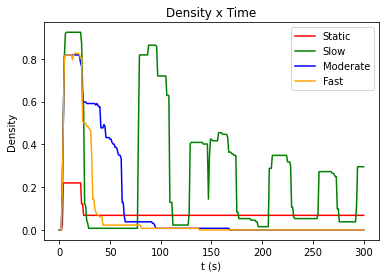

In [44]:
# densidade x tempo
plt.title("Density x Time")
plt.xlabel("t (s)")
plt.ylabel("Density")
plt.plot(timestamp, ldensity[0], label = "Static", color = "red");
plt.plot(timestamp, ldensity[1], label = "Slow", color = "green");
plt.plot(timestamp, ldensity[2], label = "Moderate", color = "blue");
plt.plot(timestamp, ldensity[3], label = "Fast", color = "orange");
plt.legend();

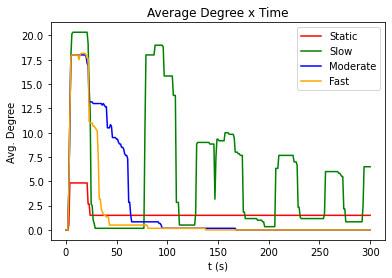

In [45]:
# degree x tempo
plt.title("Average Degree x Time")
plt.xlabel("t (s)")
plt.ylabel("Avg. Degree")
plt.plot(timestamp, ldegree[0], label = "Static", color = "red");
plt.plot(timestamp, ldegree[1], label = "Slow", color = "green");
plt.plot(timestamp, ldegree[2], label = "Moderate", color = "blue");
plt.plot(timestamp, ldegree[3], label = "Fast", color = "orange");
plt.legend();

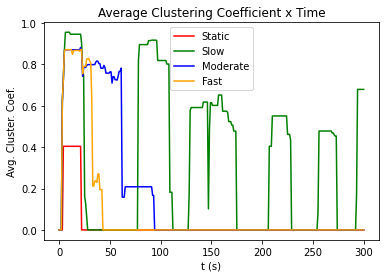

In [46]:
# clustering x tempo
plt.title("Average Clustering Coefficient x Time")
plt.xlabel("t (s)")
plt.ylabel("Avg. Cluster. Coef.")
plt.plot(timestamp, lclustering[0], label = "Static", color = "red");
plt.plot(timestamp, lclustering[1], label = "Slow", color = "green");
plt.plot(timestamp, lclustering[2], label = "Moderate", color = "blue");
plt.plot(timestamp, lclustering[3], label = "Fast", color = "orange");
plt.legend();

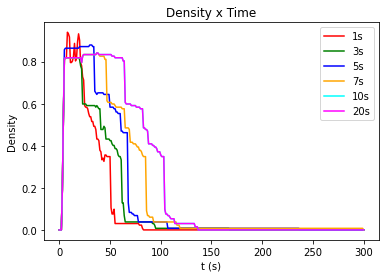

In [26]:
# densidade x tempo
plt.title("Density x Time")
plt.xlabel("t (s)")
plt.ylabel("Density")
plt.plot(timestamp, ldensity[0], label = "1s", color = "red");
plt.plot(timestamp, ldensity[1], label = "3s", color = "green");
plt.plot(timestamp, ldensity[2], label = "5s", color = "blue");
plt.plot(timestamp, ldensity[3], label = "7s", color = "orange");
plt.plot(timestamp, ldensity[4], label = "10s", color = "cyan");
plt.plot(timestamp, ldensity[4], label = "20s", color = "magenta");
plt.legend();